In [4]:
from sionna.channel import AWGN
from sionna.utils import BinarySource, ebnodb2no
from sionna.mapping import Mapper, Demapper, Constellation
from sionna.utils import sim_ber
import sionna as sn
import matplotlib as mpl

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv1D, Activation

In [ ]:
import utils
from utils.my_utils import load_weights, one_hot_Mqam, Normalize, bit2onehot
import sys
sys.path.append('..')
from config import WEIGHTS_PATH

In [ ]:
#Intialized Parameters
n = 6000
num_bits_per_symbol = 4
M = 2**num_bits_per_symbol
coderate = 1.0
n_channel = 1
num_symbols_per_codeword = n//num_bits_per_symbol

#Training parameters
weights_path = WEIGHTS_PATH

### Model

In [13]:
class E2E_AE_CNN(Model):
    def __init__(self, training):
        super().__init__()
        self._training = training
        self._binary_source = BinarySource()

        # Transmitter
        self.conv1 = Conv1D(32, kernel_size=3, strides=1, padding='same')
        self.conv2 = Conv1D(16, kernel_size=3, strides=1, padding='same')
        self.dense_tx = Dense(2*n_channel)  # Outputs real and imaginary parts

        # Channel
        self._channel = AWGN()

        # Receiver
        self.conv3 = Conv1D(16, kernel_size=3, strides=1, padding='same')
        self.conv4 = Conv1D(32, kernel_size=3, strides=1, padding='same')
        self.dense_rx = Dense(2**num_bits_per_symbol, activation= 'softmax')

        if self._training:
            self._ce = tf.keras.losses.CategoricalCrossentropy()

    @tf.function()
    def call(self, batch_size, ebno_db):
        batch_size = tf.cast(batch_size, dtype=tf.int32)
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol = num_bits_per_symbol, coderate=1.0)


        b = self._binary_source([batch_size, n])
        _,indices,s_initial = bit2onehot(b,num_bits_per_symbol, batch_size,num_symbols_per_codeword)
        ##############
        ## Transmitter
        ##############
        x = self.conv1(s_initial)
        x = Activation('relu')(x)

        x = self.conv2(x)
        x = Activation('relu')(x)


        x = self.dense_tx(x)
        x_real = x[:,:,:n_channel]
        x_img  = x[:,:,n_channel:]
        x = tf.cast(tf.complex(x_real, x_img), dtype=tf.complex64)
        x = Normalize(x)
        #############
        ## Channel
        #############
        y = self._channel([x, no])

        #############
        ## Receiver
        #############
        y = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=-1)

        y = self.conv3(y)
        y = Activation('relu')(y)

        y = self.conv4(y)
        y = Activation('relu')(y)

        prob = self.dense_rx(y)


        if self._training:
            loss = self._ce(s_initial, prob)
            return loss
        else:
            s_hat = tf.argmax(prob, axis = -1)
            return indices,s_hat

In [14]:
class E2E_AE_DNN(Model):
    def __init__(self, training):
        super().__init__()

        self._training = training
        self._binary_source = BinarySource()


        ## Transmitter
        self.dense_1 = Dense(2**num_bits_per_symbol, 'relu')
        self.dense_2 = Dense(2**num_bits_per_symbol, 'relu')
        self.dense_3 = Dense(2 * n_channel, None)

        ## Channel
        self._channel = AWGN()


        ## Receiver
        self.dense_4 = Dense(2**num_bits_per_symbol, 'relu')
        self.dense_5 = Dense(2**num_bits_per_symbol, 'relu')
        self.output_layer = Dense(2**num_bits_per_symbol, 'softmax')

        # Loss function
        if self._training:
            self._ce = tf.keras.losses.CategoricalCrossentropy()
    @tf.function()
    def call(self, batch_size, ebno_db):
        batch_size = tf.cast(batch_size, dtype = tf.int32)

        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol = num_bits_per_symbol, coderate=1.0)
        
        b = self._binary_source([batch_size, n])

        ################
        ## Transmitter
        ################

        _,indices,s_initial = bit2onehot(b,num_bits_per_symbol, batch_size,num_symbols_per_codeword)

        s = self.dense_1(s_initial)
        s = self.dense_2(s)
        s = self.dense_3(s)
        x_real = s[:,:,:n_channel]
        x_img  = s[:,:,n_channel:]
        x = tf.cast(tf.complex(x_real, x_img), dtype=tf.complex64)
        x = Normalize(x)


        ################
        ## Channel
        ################
        y = self._channel([x, no])
        ################
        ## Receiver
        ################
        y = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=-1)
        s_hat = self.dense_4(y)
        s_hat = self.dense_5(s_hat)
        prob = self.output_layer(s_hat)

        if self._training:
            loss = self._ce(s_initial, prob)
            return loss
        else:
            s_hat = tf.argmax(prob, axis = -1)
            # _,b_hat = indices_to_bits(s_hat, num_bits_per_symbol,batch_size) # convert to bits
            return indices,s_hat

### Trainable Constellation

In [15]:
model_weights_AE_CNN = weights_path + f'/weights of AE_CNN_16QAM_SER_12'
model = E2E_AE_CNN(training=False)
load_weights(model,model_weights_AE_CNN)
one_hot_input = one_hot_Mqam(M)
one_hot_input = tf.expand_dims(one_hot_input, axis=0)
s = model.conv1(one_hot_input)
s = Activation('relu')(s)
s = model.conv2(s)
s = Activation('relu')(s)
s = model.dense_tx(s)
xcnn_real = s[:, :, :n_channel]
xcnn_img = s[:, :, n_channel:]
xcnn = tf.cast(tf.complex(xcnn_real, xcnn_img), dtype=tf.complex64)
xcnn = Normalize(xcnn)
xcnn = tf.squeeze(xcnn).numpy()


In [17]:
model_weights_AE_DNN = weights_path + f'/weights of AE_DNN_16QAM_SER_12'
model = E2E_AE_DNN(training=False)
load_weights(model,model_weights_AE_DNN)
one_hot_input = one_hot_Mqam(M)
one_hot_input = tf.expand_dims(one_hot_input, axis=0)


s = model.dense_1(one_hot_input)
s = model.dense_2(s)
s = model.dense_3(s)
xdnn_real = s[:, :, :n_channel]
xdnn_img = s[:, :, n_channel:]
xdnn = tf.cast(tf.complex(xdnn_real, xdnn_img), dtype=tf.complex64)
xdnn = Normalize(xdnn)
xdnn = tf.squeeze(xdnn).numpy()

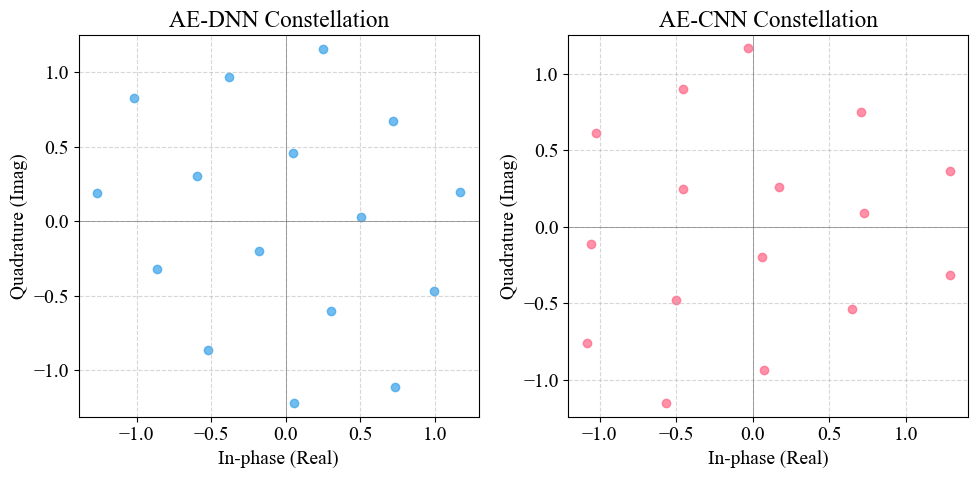

In [53]:
# Set global font settings
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.size'] = 14

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Wider figure for side-by-side

# First plot: xdnn
axs[0].scatter(tf.math.real(xdnn), tf.math.imag(xdnn), color='#36A2EB', alpha=0.7)
axs[0].axhline(0, color='gray', linewidth=0.5)
axs[0].axvline(0, color='gray', linewidth=0.5)
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].set_title("AE-DNN Constellation")
axs[0].set_xlabel("In-phase (Real)")
axs[0].set_ylabel("Quadrature (Imag)")
axs[0].axis('equal')

# Second plot: another constellation (e.g., baseline, replace xcnn as needed)
axs[1].scatter(tf.math.real(xcnn), tf.math.imag(xcnn), color='#FF6384', alpha=0.7)
axs[1].axhline(0, color='gray', linewidth=0.5)
axs[1].axvline(0, color='gray', linewidth=0.5)
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].set_title("AE-CNN Constellation")
axs[1].set_xlabel("In-phase (Real)")
axs[1].set_ylabel("Quadrature (Imag)")
axs[1].axis('equal')

# Improve layout
plt.tight_layout()
plt.show()